# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Number of rows : {}'.format(len(azdias)))
print('Number of columns : {}'.format(len(azdias.columns)))
azdias.head(5)

Number of rows : 891221
Number of columns : 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print('Number of rows : {}'.format(len(feat_info)))
print('Number of columns : {}'.format(len(feat_info.columns)))
feat_info.head(5)

Number of rows : 85
Number of columns : 4


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
for index in range(len(azdias.columns)):
    column = azdias.columns[index]
    missing_list = feat_info.iloc[index, 3]
    missing_list = missing_list[1:-1]
    missing_list = missing_list.split(',')
    if missing_list == ['']:
        continue
    else:
        for value in missing_list:
            if value.isnumeric() == True:
                value = int(value)
                azdias.loc[azdias[column] == value, column] = np.NaN
            elif value[0] == '-':
                value = int(value)
                azdias.loc[azdias[column] == value, column] = np.NaN
            else:
                azdias.loc[azdias[column] == value, column] = np.NaN

In [6]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info_attribute = feat_info.set_index('attribute')
feat_info_attribute.head(5)

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_na_columns = azdias.isna().sum()
azdias_na_columns

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

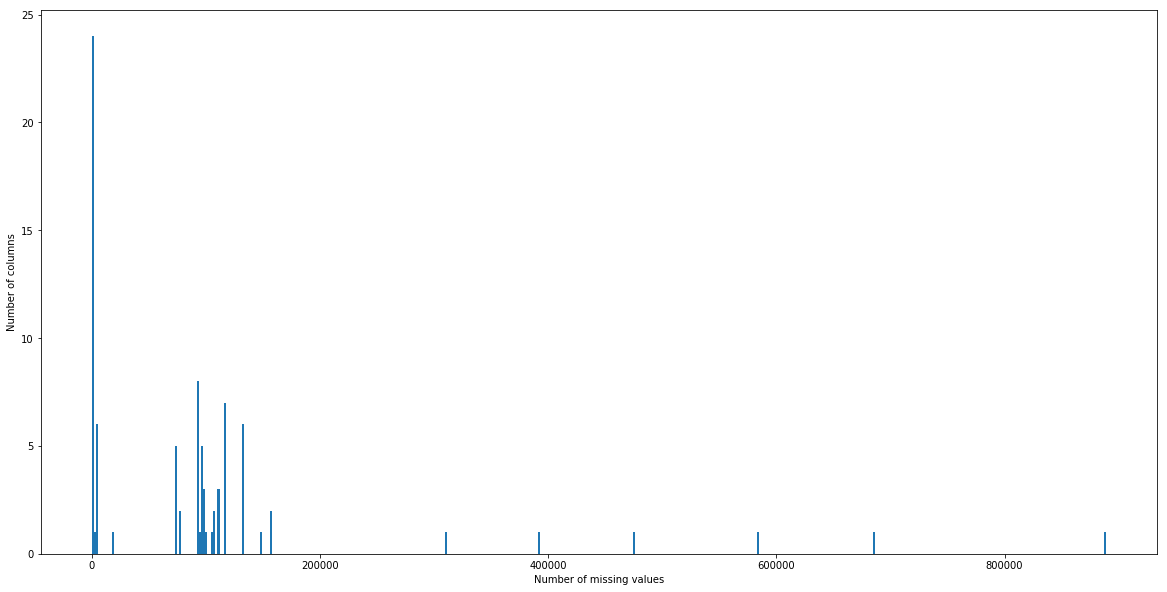

In [10]:
# Investigate patterns in the amount of missing data in each column.
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
plt.hist(x = azdias_na_columns.values, bins = 500)
plt.xlabel('Number of missing values')
plt.ylabel('Number of columns')
plt.show()

[]

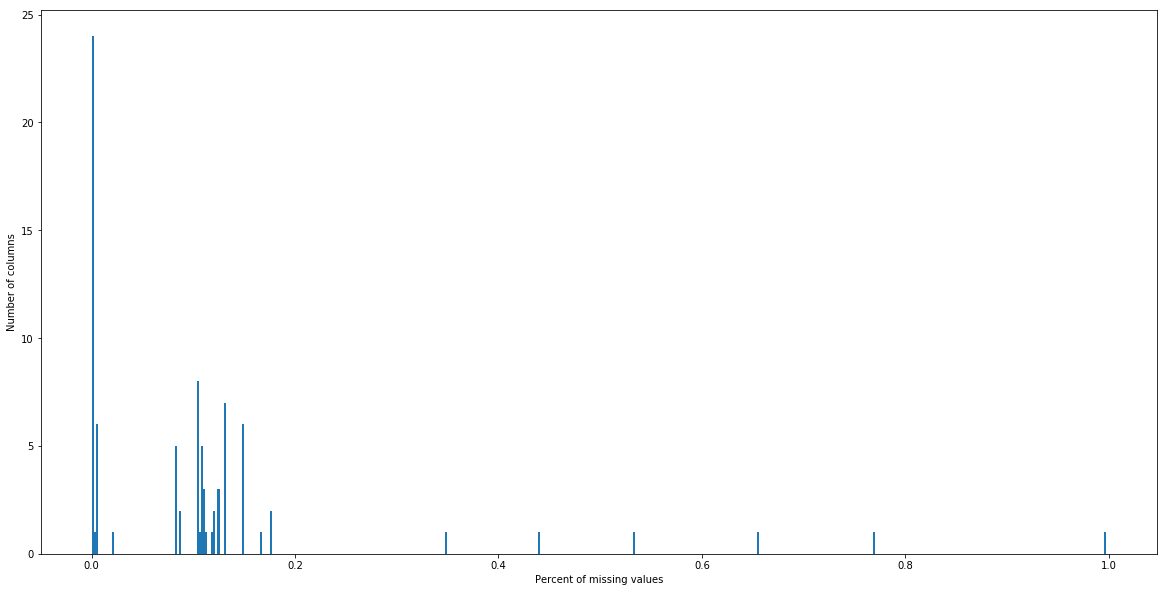

In [11]:
plt.figure(figsize = (20,10))
plt.hist(x = azdias_na_columns.values/len(azdias), bins = 500)
plt.xlabel('Percent of missing values')
plt.ylabel('Number of columns')
plt.plot()

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_columns = [x for x in azdias_na_columns.index if azdias_na_columns[x]/len(azdias) > 0.2]
drop_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [13]:
azdias2 = azdias.drop(columns = drop_columns)
azdias2.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data 
in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

First, I plot histogram with number of missing values of azdias columns. Then, I plot the second histogram with percent of missing values of azdias columns. I found a huge gap in the first histogram around 200,000 and there are 6 columns thet have over 200,000 of missing values. I cheched again with second histogram and there are 6 columns have more than 20% of missing values.
Rather than numbers, I chose percentage and removed columns over 20% of missing values.
They are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?
azdias_na_rows = azdias2.isna().sum(1)
azdias_na_rows

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

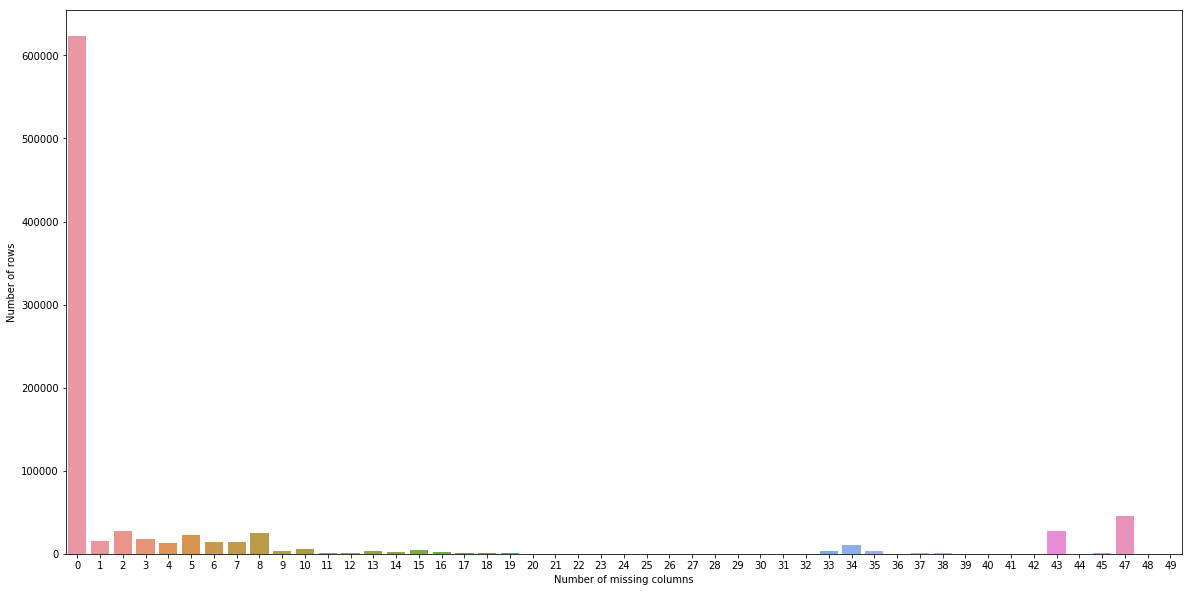

In [15]:
plt.figure(figsize=(20,10))
sns.countplot(x = azdias_na_rows)
plt.xlabel('Number of missing columns')
plt.ylabel('Number of rows')
plt.show()

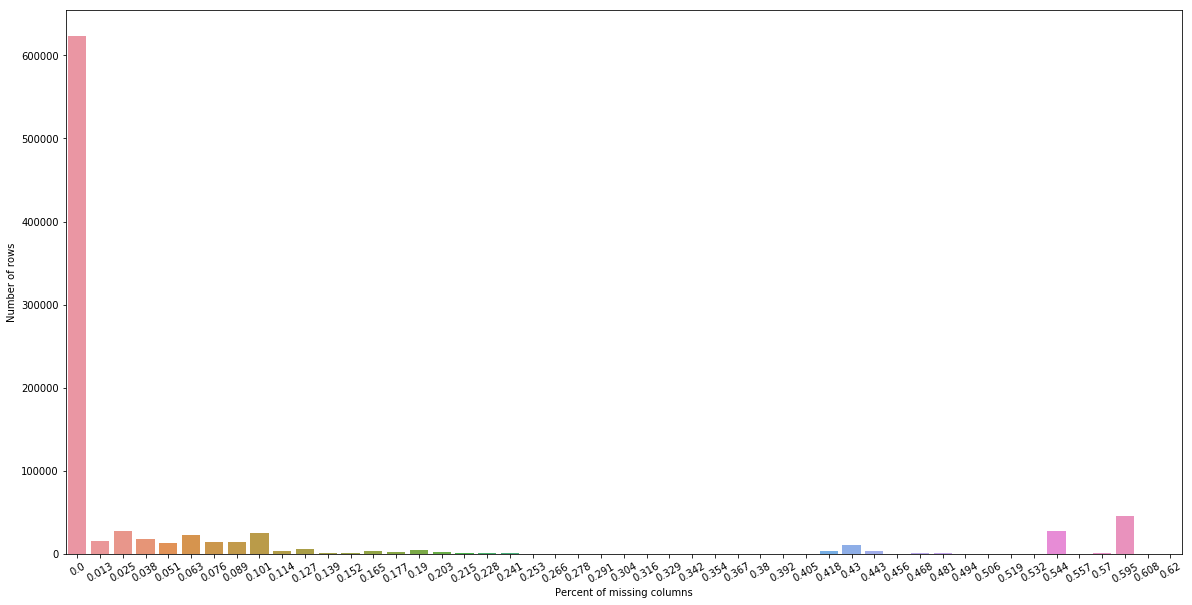

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(x = round(azdias_na_rows/len(azdias2.columns), 3))
plt.xlabel('Percent of missing columns')
plt.ylabel('Number of rows')
plt.xticks(rotation=30)
plt.show()

In [17]:
def plot_rows_chart(azdias2):
    azdias_na_rows = azdias2.isna().sum(1)
    plt.figure(figsize=(20,10))
    sns.countplot(x = azdias_na_rows)
    plt.xlabel('Number of missing columns')
    plt.ylabel('Number of rows')
    plt.show()

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias2_row_over = azdias2[azdias_na_rows > 30]
azdias2_row_under = azdias2[azdias_na_rows <= 30]

In [19]:
azdias2_row_over.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
azdias2_row_under.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


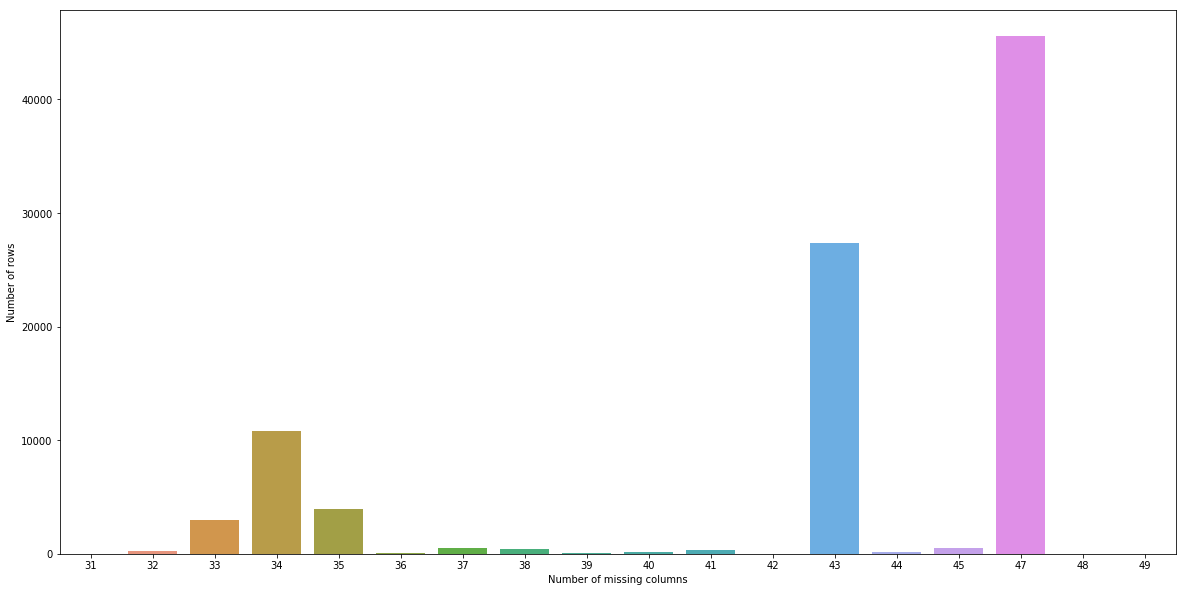

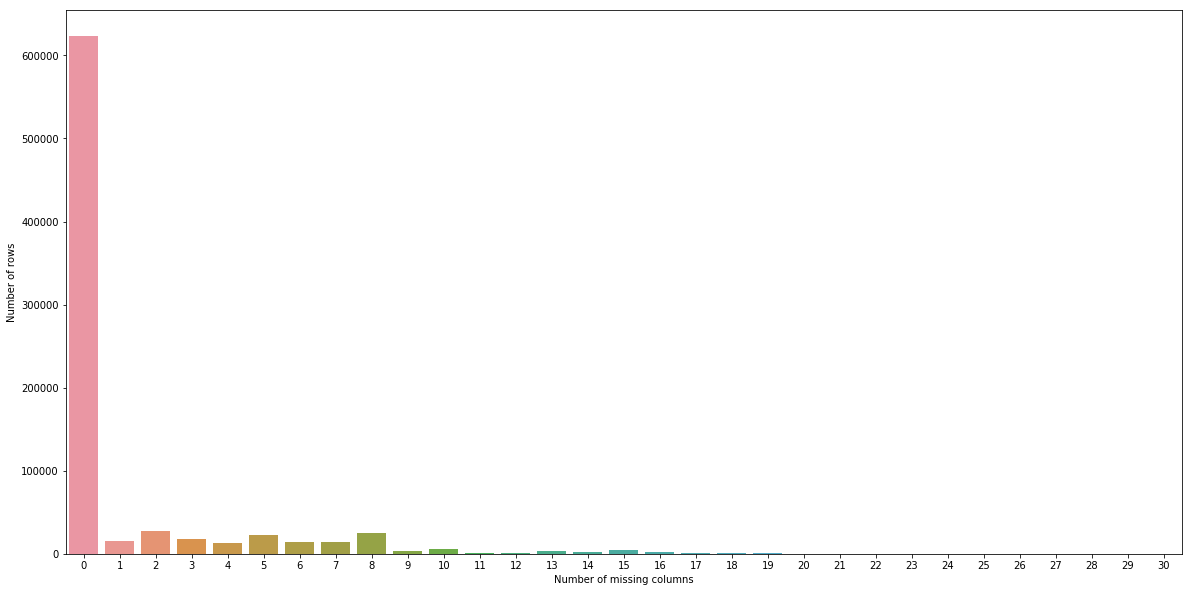

In [21]:
plt.figure(figsize = (20, 10))

plot_rows_chart(azdias2_row_over)
plot_rows_chart(azdias2_row_under)

plt.show()

In [22]:
def show_subplot(df1, df2):
    plt.figure(figsize = (20,5))
    
    plt.subplot(121)
    sns.countplot(df1)
    plt.title('Under the threshold')
    
    plt.subplot(122)
    sns.countplot(df2)
    plt.title('Over the threshold')
    
    plt.show()

ALTERSKATEGORIE_GROB


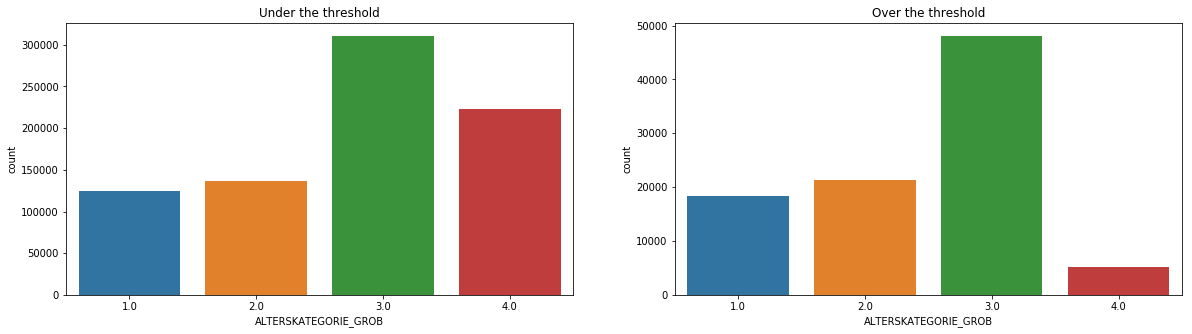

ANREDE_KZ


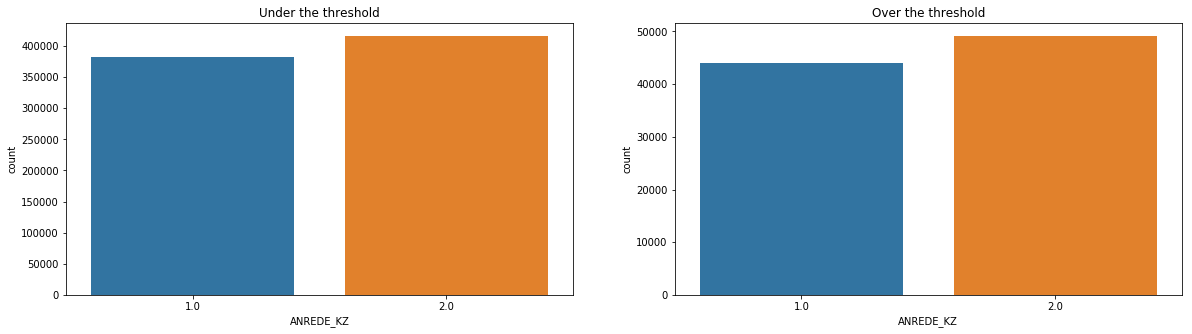

CJT_GESAMTTYP


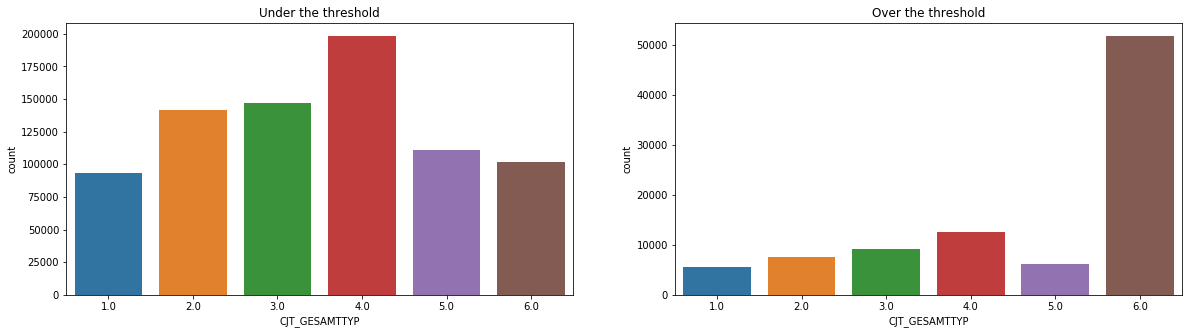

FINANZ_MINIMALIST


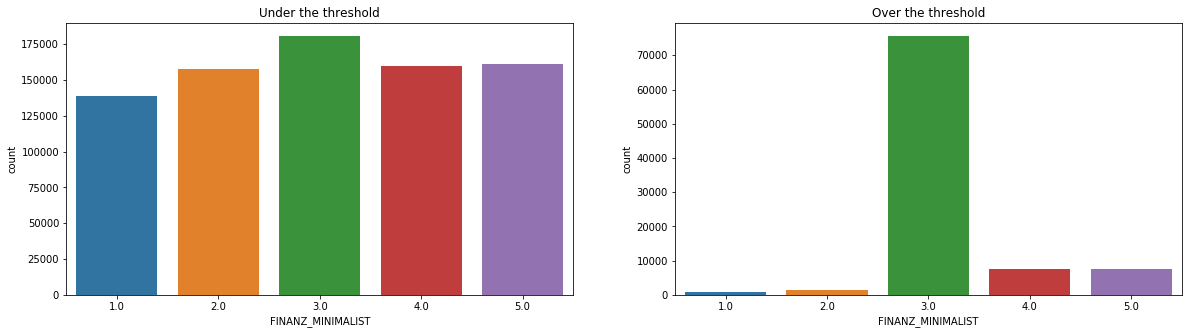

FINANZ_SPARER


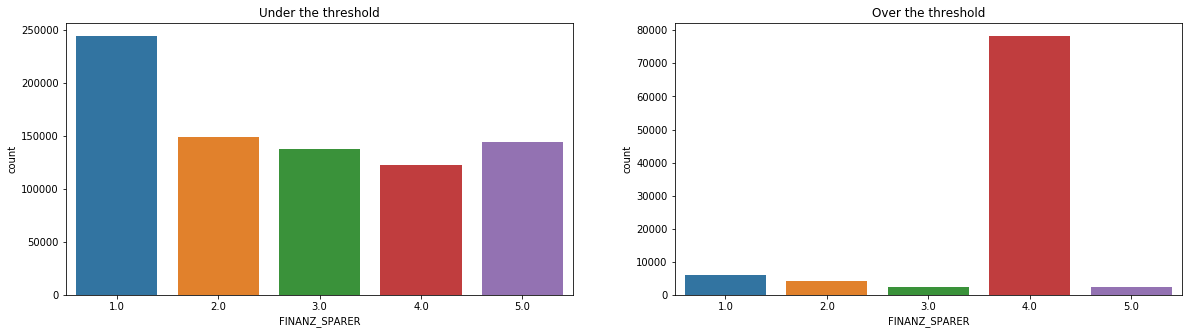

FINANZ_VORSORGER


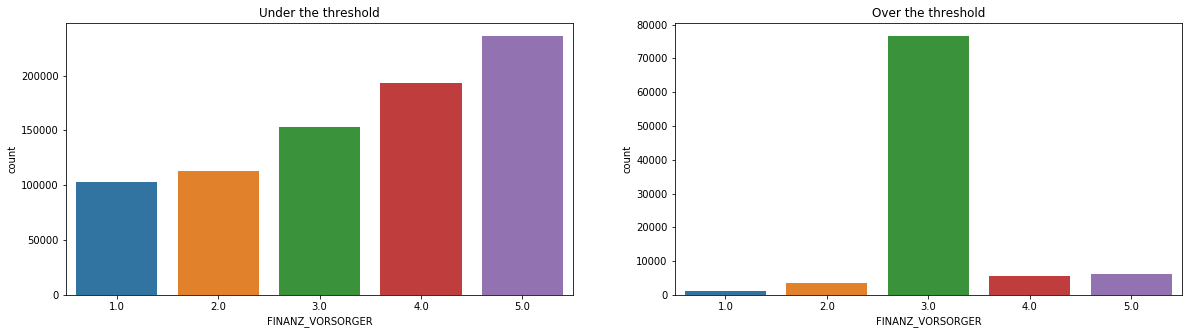

FINANZ_ANLEGER


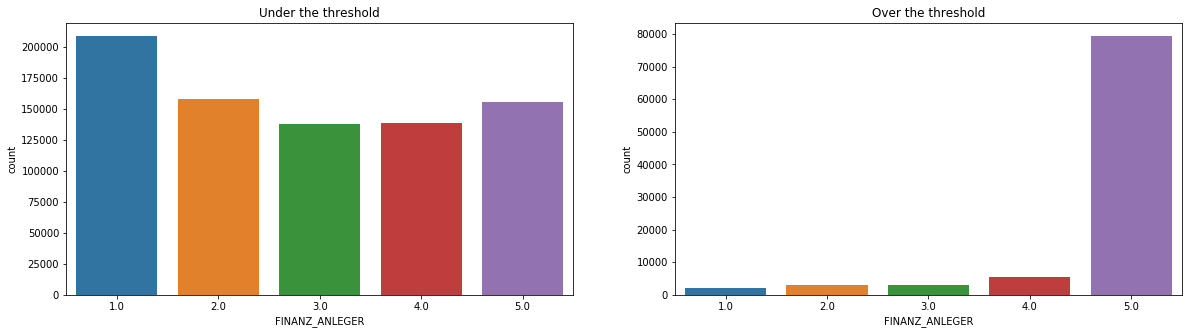

FINANZ_UNAUFFAELLIGER


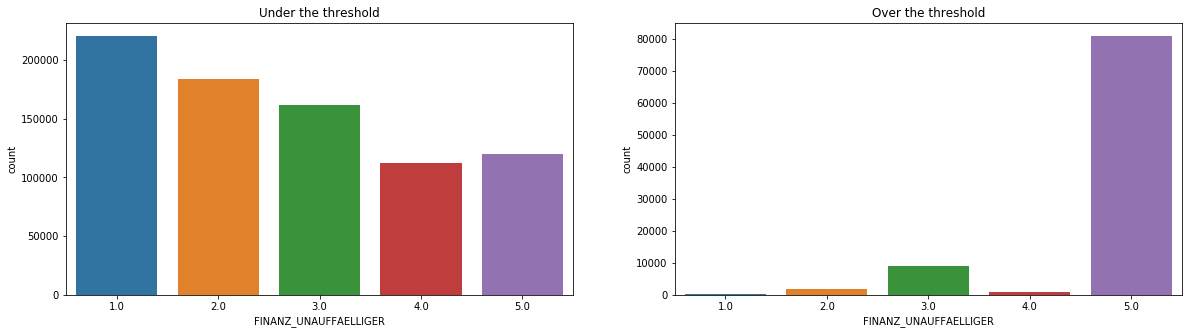

FINANZ_HAUSBAUER


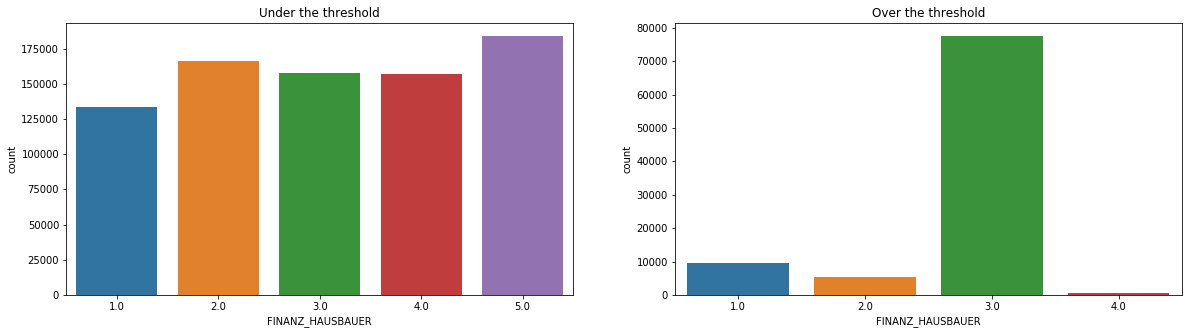

FINANZTYP


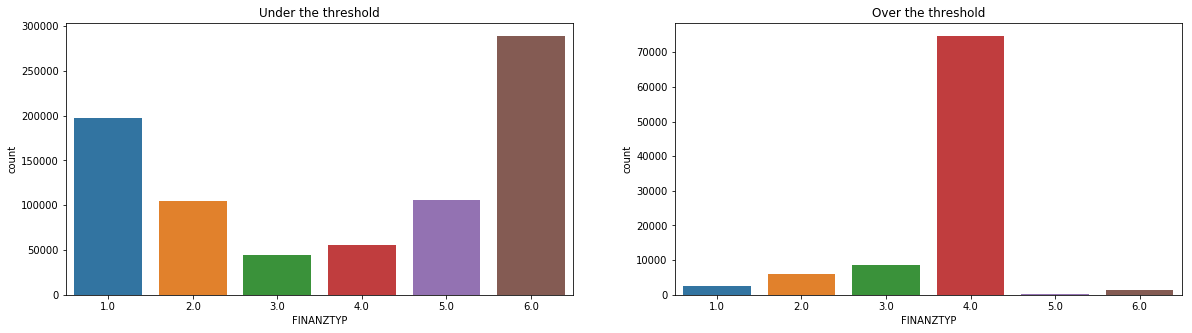

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
column_list = azdias2_row_over.columns

for column in column_list[:10]:
    print(column)
    show_subplot(azdias2_row_under[column], azdias2_row_over[column])

In [24]:
azdias3 = azdias2_row_under

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. 
Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Yes, the data with lots of missing values are largely different from data with few/no missing values. The threshold dividing two groups is 30. One group has rows that have more than 30 missing values and the other has rows that have less than or equal to 30 missing values.
I plot and compared 10 columns of two datasets and they showed diffrent distribution and different number count. This shows that lots of missing values group has different features or characters with few/no missing values group in real. People who don't want to open there information or tend to avoid surveys might have tendencies to act in certain way, or lack of time to answer because of there working time or financial problems. We need to analyze the characters of two groups.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
feat_info_new = feat_info[feat_info.attribute.isin(drop_columns) == False]
set(feat_info_new.type)

{'categorical', 'mixed', 'numeric', 'ordinal'}

In [26]:
num_categorical = len(feat_info_new[feat_info_new.type == 'categorical'])
num_mixed = len(feat_info_new[feat_info_new.type == 'mixed'])
num_numeric = len(feat_info_new[feat_info_new.type == 'numeric'])
num_ordinal = len(feat_info_new[feat_info_new.type == 'ordinal'])
print("Number of categorical types : {}".format(num_categorical))
print("Number of mixed types : {}".format(num_mixed))
print("Number of numeric types : {}".format(num_numeric))
print("Number of ordinal types : {}".format(num_ordinal))

Number of categorical types : 18
Number of mixed types : 6
Number of numeric types : 6
Number of ordinal types : 49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info_categorical = feat_info_new[feat_info_new['type'] == 'categorical']
columns_categorical = list(feat_info_categorical['attribute'])
columns_categorical

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [28]:
azdias3_categorical = azdias3.loc[:, columns_categorical]
azdias3 = azdias3.drop(columns = columns_categorical)
azdias3_categorical.head(5)

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2.0,5.0,1.0,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,W,8,8A
2,2.0,3.0,1.0,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,W,4,4C
3,2.0,2.0,6.0,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3.0,1.0,W,2,2A
4,1.0,5.0,5.0,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,1.0,W,6,6B
5,2.0,2.0,2.0,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,1.0,W,8,8C


In [29]:
for column in azdias3_categorical.columns:
    print("Name of column : {}".format(column))
    print("Number of features : {}".format(len(azdias3_categorical[column].unique())))
    print("Features of column : {}".format(azdias3_categorical[column].unique()))
    print("Data type of features : {}".format(azdias3_categorical[column].dtypes))
    print('\n')

Name of column : ANREDE_KZ
Number of features : 2
Features of column : [ 2.  1.]
Data type of features : float64


Name of column : CJT_GESAMTTYP
Number of features : 7
Features of column : [  5.   3.   2.   4.   1.   6.  nan]
Data type of features : float64


Name of column : FINANZTYP
Number of features : 6
Features of column : [ 1.  6.  5.  2.  4.  3.]
Data type of features : float64


Name of column : GFK_URLAUBERTYP
Number of features : 13
Features of column : [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
Data type of features : float64


Name of column : GREEN_AVANTGARDE
Number of features : 2
Features of column : [0 1]
Data type of features : int64


Name of column : LP_FAMILIE_FEIN
Number of features : 12
Features of column : [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
Data type of features : float64


Name of column : LP_FAMILIE_GROB
Number of features : 6
Features of column : [  3.   1.  nan   5.   2.   4.]
Data type of features : float6

In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias3_categorical['OST_WEST_KZ'] = azdias3_categorical['OST_WEST_KZ'].replace({'W' : 0, 'O': 1})
azdias3_categorical['ANREDE_KZ'] = azdias3_categorical['ANREDE_KZ'].replace({1 : 0, 2: 1})

In [31]:
encoding_list = []

for column in azdias3_categorical.columns:
    if len(azdias3_categorical[column].unique()) > 2 and len(azdias3_categorical[column].unique()) < 11:
        encoding_list.append(column)

encoding_list

['CJT_GESAMTTYP',
 'FINANZTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [32]:
keep_list = []

for column in azdias3_categorical.columns:
    if len(azdias3_categorical[column].unique()) <3:
        keep_list.append(column)

keep_list

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

In [33]:
# Delete the lists that has more than 10 categories to improve the model
delete_list = list(set(columns_categorical) - set(encoding_list) - set(keep_list))
delete_list

['LP_FAMILIE_FEIN', 'CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN']

In [34]:
#azdias3_categorical = pd.get_dummies(azdias3_categorical, columns = encoding_list)

In [35]:
azdias3_categorical.head(5)

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,1.0,5.0,1.0,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,0,8,8A
2,1.0,3.0,1.0,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,0,4,4C
3,1.0,2.0,6.0,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3.0,1.0,0,2,2A
4,0.0,5.0,5.0,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,1.0,0,6,6B
5,1.0,2.0,2.0,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,1.0,0,8,8C


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding 
categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There are 18 categorical type columns. I made a new dataframe with it and analyze features of each columns. The dataset can be divided into below:  
#### 1) 2 values(binary) - numeric  
I didn't touch them  
'GREEN_AVANTGARDE', 'SOHO_KZ'


#### 2) 2 values(not binary) - numeric or string  
There are 2 columns and I change them into binary values, which are 0 and 1.  
The reason change numeric values into 0 and 1 is that there might be hierarchies among datas but actually they are not. To prevent this, I correct them into 0 and 1.  
'OST_WEST_KZ', 'ANREDE_KZ'


#### 3) Values between 3 ~ 10  
There are 10 columns and these columns will be encoded with pd.get_dummies.*  
'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 
'GEBAEUDETYP', 'CAMEO_DEUG_2015'


#### 4) More than 10 values
There are 4 columns and these columns will be deleted due to too many values. If they are encoded, they will make too many columns that will not that much be helpful.  
'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'GFK_URLAUBERTYP'


#### *OneHotEncoding will be done after imputer. The reason is that we will reuse imputer later when analyzing customer data, but original imputer is fixed at certain number of columns. I tried several days and concluded that AZDIAS data set and CUSTOMER data set have difference in the number of columns after encoding. To prevent errors of imputer due to difference in number of columns, onehotencoding will be done next to the imputer.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [36]:
md_file = open('Data_Dictionary.md', 'r')
print(md_file.read())

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [37]:
feat_info_mixed = feat_info_new[feat_info_new['type'] == 'mixed']
columns_mixed = list(feat_info_mixed['attribute'])
columns_mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias3_mixed = azdias3.loc[:, columns_mixed]
azdias3 = azdias3.drop(columns = columns_mixed)
azdias3_mixed.head(5)

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
1,21.0,6.0,14.0,4.0,51,1.0
2,3.0,1.0,15.0,2.0,24,1.0
3,NaN,NaN,8.0,7.0,12,1.0
4,32.0,10.0,8.0,3.0,43,2.0
5,8.0,2.0,3.0,7.0,54,1.0


In [39]:
azdias3_mixed['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [40]:
azdias3_mixed['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [41]:
'''
### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''

"\n### 1.18. PRAEGENDE_JUGENDJAHRE\nDominating movement of person's youth (avantgarde vs. mainstream; east vs. west)\n- -1: unknown\n-  0: unknown\n-  1: 40s - war years (Mainstream, E+W)\n-  2: 40s - reconstruction years (Avantgarde, E+W)\n-  3: 50s - economic miracle (Mainstream, E+W)\n-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)\n-  5: 60s - economic miracle (Mainstream, E+W)\n-  6: 60s - generation 68 / student protestors (Avantgarde, W)\n-  7: 60s - opponents to the building of the Wall (Avantgarde, E)\n-  8: 70s - family orientation (Mainstream, E+W)\n-  9: 70s - peace movement (Avantgarde, E+W)\n- 10: 80s - Generation Golf (Mainstream, W)\n- 11: 80s - ecological awareness (Avantgarde, W)\n- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)\n- 13: 80s - Swords into ploughshares (Avantgarde, E)\n- 14: 90s - digital media kids (Mainstream, E+W)\n- 15: 90s - ecological awareness (Avantgarde, E+W)\n"

In [42]:
# Create a new column : 'PRAEGENDE_JUGENDJAHRE_Movement'
azdias3_mixed['PRAEGENDE_JUGENDJAHRE_Movement'] = azdias3_mixed['PRAEGENDE_JUGENDJAHRE'].isin([1, 3, 5, 8, 10, 12, 14])
azdias3_mixed['PRAEGENDE_JUGENDJAHRE_Movement'] = azdias3_mixed['PRAEGENDE_JUGENDJAHRE_Movement'].replace({True : 1, False : 0})

# Create a new column : 'PRAEGENDE_JUGENDJAHRE_Decade'
azdias3_mixed.loc[azdias3_mixed['PRAEGENDE_JUGENDJAHRE'].isin([1,2]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 40
azdias3_mixed.loc[azdias3_mixed['PRAEGENDE_JUGENDJAHRE'].isin([3,4]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 50
azdias3_mixed.loc[azdias3_mixed['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 60
azdias3_mixed.loc[azdias3_mixed['PRAEGENDE_JUGENDJAHRE'].isin([8,9]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 70
azdias3_mixed.loc[azdias3_mixed['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 80
azdias3_mixed.loc[azdias3_mixed['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 90

azdias3_mixed.head(5)

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade
1,21.0,6.0,14.0,4.0,51,1.0,1,90.0
2,3.0,1.0,15.0,2.0,24,1.0,0,90.0
3,NaN,NaN,8.0,7.0,12,1.0,1,70.0
4,32.0,10.0,8.0,3.0,43,2.0,1,70.0
5,8.0,2.0,3.0,7.0,54,1.0,1,50.0


In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

'''
### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown
'''

'\n### 4.3. CAMEO_INTL_2015\nGerman CAMEO: Wealth / Life Stage Typology, mapped to international code\n- -1: unknown\n- 11: Wealthy Households - Pre-Family Couples & Singles\n- 12: Wealthy Households - Young Couples With Children\n- 13: Wealthy Households - Families With School Age Children\n- 14: Wealthy Households - Older Families &  Mature Couples\n- 15: Wealthy Households - Elders In Retirement\n- 21: Prosperous Households - Pre-Family Couples & Singles\n- 22: Prosperous Households - Young Couples With Children\n- 23: Prosperous Households - Families With School Age Children\n- 24: Prosperous Households - Older Families & Mature Couples\n- 25: Prosperous Households - Elders In Retirement\n- 31: Comfortable Households - Pre-Family Couples & Singles\n- 32: Comfortable Households - Young Couples With Children\n- 33: Comfortable Households - Families With School Age Children\n- 34: Comfortable Households - Older Families & Mature Couples\n- 35: Comfortable Households - Elders In Retire

In [44]:
azdias3_mixed['CAMEO_INTL_2015'] = azdias3_mixed['CAMEO_INTL_2015'].astype(float)

# Create a new column 'CAMEO_INTL_2015_Wealth'
azdias3_mixed.loc[azdias3_mixed['CAMEO_INTL_2015'].isin(list(range(11,16))), 'CAMEO_INTL_2015_Wealth'] = 1
azdias3_mixed.loc[azdias3_mixed['CAMEO_INTL_2015'].isin(list(range(21,26))), 'CAMEO_INTL_2015_Wealth'] = 2
azdias3_mixed.loc[azdias3_mixed['CAMEO_INTL_2015'].isin(list(range(31,36))), 'CAMEO_INTL_2015_Wealth'] = 3
azdias3_mixed.loc[azdias3_mixed['CAMEO_INTL_2015'].isin(list(range(41,46))), 'CAMEO_INTL_2015_Wealth'] = 4
azdias3_mixed.loc[azdias3_mixed['CAMEO_INTL_2015'].isin(list(range(51,56))), 'CAMEO_INTL_2015_Wealth'] = 5

# Create a new column 'CAMEO_INTL_2015_LifeStage'
azdias3_mixed.loc[azdias3_mixed['CAMEO_INTL_2015'].isin([11,21,31,41,51]), 'CAMEO_INTL_2015_LifeStage'] = 5
azdias3_mixed.loc[azdias3_mixed['CAMEO_INTL_2015'].isin([12,22,32,42,52]), 'CAMEO_INTL_2015_LifeStage'] = 4
azdias3_mixed.loc[azdias3_mixed['CAMEO_INTL_2015'].isin([13,23,33,43,53]), 'CAMEO_INTL_2015_LifeStage'] = 3
azdias3_mixed.loc[azdias3_mixed['CAMEO_INTL_2015'].isin([14,24,34,44,54]), 'CAMEO_INTL_2015_LifeStage'] = 2
azdias3_mixed.loc[azdias3_mixed['CAMEO_INTL_2015'].isin([15,25,35,45,55]), 'CAMEO_INTL_2015_LifeStage'] = 1


azdias3_mixed.head(5)

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_LifeStage
1,21.0,6.0,14.0,4.0,51.0,1.0,1,90.0,5.0,5.0
2,3.0,1.0,15.0,2.0,24.0,1.0,0,90.0,2.0,2.0
3,NaN,NaN,8.0,7.0,12.0,1.0,1,70.0,1.0,4.0
4,32.0,10.0,8.0,3.0,43.0,2.0,1,70.0,4.0,3.0
5,8.0,2.0,3.0,7.0,54.0,1.0,1,50.0,5.0,2.0


In [45]:
azdias3_mixed = azdias3_mixed.drop(columns = columns_mixed)
azdias3_mixed

,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_LifeStage
1,1,90.0,5.0,5.0
2,0,90.0,2.0,2.0
3,1,70.0,1.0,4.0
4,1,70.0,4.0,3.0
5,1,50.0,5.0,2.0
6,1,80.0,2.0,4.0
7,1,70.0,1.0,2.0
8,0,80.0,1.0,3.0
9,0,90.0,1.0,1.0
10,1,50.0,5.0,5.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding 
mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I created 4 new columns and deleted all of 6 original columns. 

#### 1) Created new columns  
We have 2 mixed type columns, 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'. Each of them can be divided into 2 features.


'PRAEGENDE_JUGENDJAHRE'  
'PRAEGENDE_JUGENDJAHRE' is divided into 'PJ_Movement' and 'PJ_Decade'. Former one means 'movement' and latter one means 'decade'.


'CAMEO_INTL_2015'  
'CAMEO_INTL_2015' is divided into 'CL2_Wealth' and 'CL2_LifeStage'. Former one means 'wealth' and the latter one means 'life stage'.



#### 2) Removed original columns  
'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'  
I created 4 new columns that preserve the characters of original data and have specific features. We don't need to let original features because they are duplicated and original ones are hard to analyze. I deleted them, 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'.

'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'  
They have dataset which is really hard to divide into certain groups. They have too much variables to one-hot-encode, so I decided to gave up them.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Columns over 10 categories are removed because too many columns may degrade model efficiency (drop_list)
azdias3_categorical = azdias3_categorical.drop(columns = delete_list)
azdias4 = pd.concat([azdias3, azdias3_categorical, azdias3_mixed], axis = 1)

azdias4.head(5)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_LifeStage
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,1.0,2.0,5.0,8.0,0,8,1,90.0,5.0,5.0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,0.0,1.0,5.0,1.0,0,4,0,90.0,2.0,2.0
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,5.0,...,0.0,1.0,3.0,1.0,0,2,1,70.0,1.0,4.0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,0.0,2.0,4.0,1.0,0,6,1,70.0,4.0,3.0
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,3.0,2.0,...,0.0,2.0,4.0,1.0,0,8,1,50.0,5.0,2.0


In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


In [48]:
azdias4.isna().sum()

ALTERSKATEGORIE_GROB               2803
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
HEALTH_TYP                        36726
RETOURTYP_BK_S                     4749
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0
SEMIO_ERL                             0
SEMIO_KULT                            0
SEMIO_RAT                             0
SEMIO_KRIT                            0
SEMIO_DOM                             0
SEMIO_KAEM                            0
SEMIO_PFLICHT                         0
SEMIO_TRADV                           0
ANZ_PERSONEN                          0
ANZ_TITEL                             0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [49]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index in range(len(df.columns)):
        column = df.columns[index]
        missing_list = feat_info.iloc[index, 3]
        missing_list = missing_list[1:-1]
        missing_list = missing_list.split(',')
        if missing_list == ['']:
            continue
        else:
            for value in missing_list:
                if value.isnumeric() == True:
                    value = int(value)
                    df.loc[df[column] == value, column] = np.NaN
                elif value[0] == '-':
                    value = int(value)
                    df.loc[df[column] == value, column] = np.NaN
                else:
                    df.loc[df[column] == value, column] = np.NaN

    drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(columns = drop_columns)
    
    columns_categorical = ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
                           'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ',
                           'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    delete_list = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'GFK_URLAUBERTYP']
    df_cat = df[columns_categorical]
    df_cat = df_cat.drop(columns = delete_list)
    df = df.drop(columns = columns_categorical)
    
    df_cat['OST_WEST_KZ'] = df_cat['OST_WEST_KZ'].replace({'W' : 0, 'O': 1})
    df_cat['ANREDE_KZ'] = df_cat['ANREDE_KZ'].replace({1 : 0, 2: 1})
    
    columns_mixed = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
    df_mix = df[columns_mixed]
    df = df.drop(columns = columns_mixed)  
    
    df_mix['PRAEGENDE_JUGENDJAHRE_Movement'] = df_mix['PRAEGENDE_JUGENDJAHRE'].isin([1, 3, 5, 8, 10, 12, 14])
    df_mix['PRAEGENDE_JUGENDJAHRE_Movement'] = df_mix['PRAEGENDE_JUGENDJAHRE_Movement'].replace({True : 1, False : 0})

    df_mix.loc[df_mix['PRAEGENDE_JUGENDJAHRE'].isin([1,2]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 40
    df_mix.loc[df_mix['PRAEGENDE_JUGENDJAHRE'].isin([3,4]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 50
    df_mix.loc[df_mix['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 60
    df_mix.loc[df_mix['PRAEGENDE_JUGENDJAHRE'].isin([8,9]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 70
    df_mix.loc[df_mix['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 80
    df_mix.loc[df_mix['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), 'PRAEGENDE_JUGENDJAHRE_Decade'] = 90
    
    df_mix['CAMEO_INTL_2015'] = df_mix['CAMEO_INTL_2015'].astype(float)
    
    df_mix.loc[df_mix['CAMEO_INTL_2015'].isin(list(range(11,16))), 'CAMEO_INTL_2015_Wealth'] = 1
    df_mix.loc[df_mix['CAMEO_INTL_2015'].isin(list(range(21,26))), 'CAMEO_INTL_2015_Wealth'] = 2
    df_mix.loc[df_mix['CAMEO_INTL_2015'].isin(list(range(31,36))), 'CAMEO_INTL_2015_Wealth'] = 3
    df_mix.loc[df_mix['CAMEO_INTL_2015'].isin(list(range(41,46))), 'CAMEO_INTL_2015_Wealth'] = 4
    df_mix.loc[df_mix['CAMEO_INTL_2015'].isin(list(range(51,56))), 'CAMEO_INTL_2015_Wealth'] = 5

    df_mix.loc[df_mix['CAMEO_INTL_2015'].isin([11,21,31,41,51]), 'CAMEO_INTL_2015_LifeStage'] = 5
    df_mix.loc[df_mix['CAMEO_INTL_2015'].isin([12,22,32,42,52]), 'CAMEO_INTL_2015_LifeStage'] = 4
    df_mix.loc[df_mix['CAMEO_INTL_2015'].isin([13,23,33,43,53]), 'CAMEO_INTL_2015_LifeStage'] = 3
    df_mix.loc[df_mix['CAMEO_INTL_2015'].isin([14,24,34,44,54]), 'CAMEO_INTL_2015_LifeStage'] = 2
    df_mix.loc[df_mix['CAMEO_INTL_2015'].isin([15,25,35,45,55]), 'CAMEO_INTL_2015_LifeStage'] = 1
    
    # remove selected columns and rows, ...
    df_mix = df_mix.drop(columns = columns_mixed)  
    
    df = pd.concat([df, df_cat, df_mix], axis = 1)
        
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [50]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias4.isna().sum()

ALTERSKATEGORIE_GROB               2803
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
HEALTH_TYP                        36726
RETOURTYP_BK_S                     4749
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0
SEMIO_ERL                             0
SEMIO_KULT                            0
SEMIO_RAT                             0
SEMIO_KRIT                            0
SEMIO_DOM                             0
SEMIO_KAEM                            0
SEMIO_PFLICHT                         0
SEMIO_TRADV                           0
ANZ_PERSONEN                          0
ANZ_TITEL                             0


In [51]:
azdias4.dtypes

ALTERSKATEGORIE_GROB              float64
FINANZ_MINIMALIST                 float64
FINANZ_SPARER                     float64
FINANZ_VORSORGER                  float64
FINANZ_ANLEGER                    float64
FINANZ_UNAUFFAELLIGER             float64
FINANZ_HAUSBAUER                  float64
HEALTH_TYP                        float64
RETOURTYP_BK_S                    float64
SEMIO_SOZ                         float64
SEMIO_FAM                         float64
SEMIO_REL                         float64
SEMIO_MAT                         float64
SEMIO_VERT                        float64
SEMIO_LUST                        float64
SEMIO_ERL                         float64
SEMIO_KULT                        float64
SEMIO_RAT                         float64
SEMIO_KRIT                        float64
SEMIO_DOM                         float64
SEMIO_KAEM                        float64
SEMIO_PFLICHT                     float64
SEMIO_TRADV                       float64
ANZ_PERSONEN                      

In [52]:
azdias4.isna().sum()

ALTERSKATEGORIE_GROB               2803
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
HEALTH_TYP                        36726
RETOURTYP_BK_S                     4749
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0
SEMIO_ERL                             0
SEMIO_KULT                            0
SEMIO_RAT                             0
SEMIO_KRIT                            0
SEMIO_DOM                             0
SEMIO_KAEM                            0
SEMIO_PFLICHT                         0
SEMIO_TRADV                           0
ANZ_PERSONEN                          0
ANZ_TITEL                             0


In [53]:
len(azdias4)

798067

In [54]:
from sklearn.preprocessing import Imputer

imp_num = Imputer(missing_values = np.NaN, strategy = 'median')
imp_cat = Imputer(missing_values = np.NaN, strategy = 'most_frequent')

categorical_features = list(feat_info.loc[feat_info['type'] == 'categorical', 'attribute'])
column_list = list(azdias4.columns)
categorical_list = list(set(categorical_features) & set(column_list))
non_categorical_list = list(set(column_list) - set(categorical_list))

azdias4[categorical_list] = imp_cat.fit_transform(azdias4[categorical_list])
azdias4[non_categorical_list] = imp_num.fit_transform(azdias4[non_categorical_list])

In [55]:
azdias4

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_LifeStage
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,1.0,2.0,5.0,8.0,0.0,8.0,1.0,90.0,5.0,5.0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,0.0,1.0,5.0,1.0,0.0,4.0,0.0,90.0,2.0,2.0
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,5.0,...,0.0,1.0,3.0,1.0,0.0,2.0,1.0,70.0,1.0,4.0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,0.0,2.0,4.0,1.0,0.0,6.0,1.0,70.0,4.0,3.0
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,3.0,2.0,...,0.0,2.0,4.0,1.0,0.0,8.0,1.0,50.0,5.0,2.0
6,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,4.0,2.0,...,0.0,1.0,4.0,1.0,0.0,4.0,1.0,80.0,2.0,4.0
7,1.0,3.0,3.0,4.0,1.0,3.0,2.0,1.0,5.0,7.0,...,0.0,1.0,1.0,8.0,0.0,2.0,1.0,70.0,1.0,2.0
8,3.0,4.0,4.0,2.0,4.0,2.0,2.0,3.0,4.0,4.0,...,0.0,2.0,6.0,3.0,0.0,1.0,0.0,80.0,1.0,3.0
9,3.0,2.0,4.0,2.0,3.0,5.0,4.0,2.0,4.0,2.0,...,0.0,2.0,4.0,3.0,0.0,1.0,0.0,90.0,1.0,1.0
10,3.0,2.0,2.0,5.0,3.0,1.0,5.0,2.0,5.0,5.0,...,0.0,2.0,3.0,1.0,0.0,9.0,1.0,50.0,5.0,5.0


In [56]:
encoding_list

['CJT_GESAMTTYP',
 'FINANZTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [57]:
azdias4 = pd.get_dummies(azdias4, columns = encoding_list)

In [58]:
azdias4

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,0,0,0,0,1,0,0,0,0,0
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,5.0,...,0,0,1,0,0,0,0,0,0,0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,3.0,2.0,...,0,0,0,0,0,0,0,0,1,0
6,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,4.0,2.0,...,0,0,0,0,1,0,0,0,0,0
7,1.0,3.0,3.0,4.0,1.0,3.0,2.0,1.0,5.0,7.0,...,1,0,1,0,0,0,0,0,0,0
8,3.0,4.0,4.0,2.0,4.0,2.0,2.0,3.0,4.0,4.0,...,0,1,0,0,0,0,0,0,0,0
9,3.0,2.0,4.0,2.0,3.0,5.0,4.0,2.0,4.0,2.0,...,0,1,0,0,0,0,0,0,0,0
10,3.0,2.0,2.0,5.0,3.0,1.0,5.0,2.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,1


In [59]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
result = scaler.fit_transform(azdias4)
result

array([[-1.76664738, -1.49459417,  1.53792006, ..., -0.32896829,
         2.16204929, -0.39598391],
       [ 0.20052231, -1.49459417,  0.86456024, ..., -0.32896829,
        -0.46252415, -0.39598391],
       [ 1.18410716,  0.68314513, -0.48215941, ..., -0.32896829,
        -0.46252415, -0.39598391],
       ..., 
       [-0.78306254, -0.76868107,  0.86456024, ..., -0.32896829,
        -0.46252415, -0.39598391],
       [-1.76664738, -1.49459417,  1.53792006, ..., -0.32896829,
        -0.46252415,  2.52535512],
       [ 1.18410716,  0.68314513, -0.48215941, ..., -0.32896829,
        -0.46252415, -0.39598391]])

In [60]:
azdias5 = pd.DataFrame(result, columns = azdias4.columns)
azdias5

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0
0,-1.766647,-1.494594,1.537920,-1.040686,1.465965,0.958633,1.339319,1.096615,-1.686349,0.443205,...,2.057697,-0.218017,-0.341222,-0.349286,-0.386903,-0.272884,-0.391094,-0.328968,2.162049,-0.395984
1,0.200522,-1.494594,0.864560,-1.766972,-0.570999,0.244109,1.339319,1.096615,-0.307722,-0.072013,...,-0.485980,-0.218017,-0.341222,-0.349286,2.584626,-0.272884,-0.391094,-0.328968,-0.462524,-0.395984
2,1.184107,0.683145,-0.482159,1.138172,-0.570999,-1.184938,-0.791197,-0.256992,-0.997036,0.443205,...,-0.485980,-0.218017,2.930647,-0.349286,-0.386903,-0.272884,-0.391094,-0.328968,-0.462524,-0.395984
3,0.200522,0.683145,0.191200,0.411886,-1.249987,0.244109,-0.791197,1.096615,1.070905,0.958423,...,-0.485980,-0.218017,-0.341222,-0.349286,-0.386903,-0.272884,2.556931,-0.328968,-0.462524,-0.395984
4,-1.766647,-0.042768,-1.155519,1.138172,-0.570999,-0.470414,1.339319,1.096615,-0.307722,-1.102449,...,-0.485980,-0.218017,-0.341222,-0.349286,-0.386903,-0.272884,-0.391094,-0.328968,2.162049,-0.395984
5,-0.783063,-1.494594,1.537920,-1.766972,1.465965,0.958633,-0.081025,-0.256992,0.381591,-1.102449,...,-0.485980,-0.218017,-0.341222,-0.349286,2.584626,-0.272884,-0.391094,-0.328968,-0.462524,-0.395984
6,-1.766647,-0.042768,0.191200,0.411886,-1.249987,0.244109,-0.791197,-1.610600,1.070905,1.473641,...,2.057697,-0.218017,2.930647,-0.349286,-0.386903,-0.272884,-0.391094,-0.328968,-0.462524,-0.395984
7,0.200522,0.683145,0.864560,-1.040686,0.786977,-0.470414,-0.791197,1.096615,0.381591,-0.072013,...,-0.485980,4.586801,-0.341222,-0.349286,-0.386903,-0.272884,-0.391094,-0.328968,-0.462524,-0.395984
8,0.200522,-0.768681,0.864560,-1.040686,0.107989,1.673157,0.629147,-0.256992,0.381591,-1.102449,...,-0.485980,4.586801,-0.341222,-0.349286,-0.386903,-0.272884,-0.391094,-0.328968,-0.462524,-0.395984
9,0.200522,-0.768681,-0.482159,1.138172,0.107989,-1.184938,1.339319,-0.256992,1.070905,0.443205,...,-0.485980,-0.218017,-0.341222,-0.349286,-0.386903,-0.272884,-0.391094,-0.328968,-0.462524,2.525355


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I divided the dataset into two groups : categorical and non-categorical. I made two independent imputers for each of them and applied independently. The reason is, when I deal with customer datset with only one imputer, some data are changed to strange values that are not shown in original data. That made the encder to generate wrong column names.  
I spent a lot of times finding the cause of problem and decided to divide imputers. The result, it works.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [61]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(azdias5)

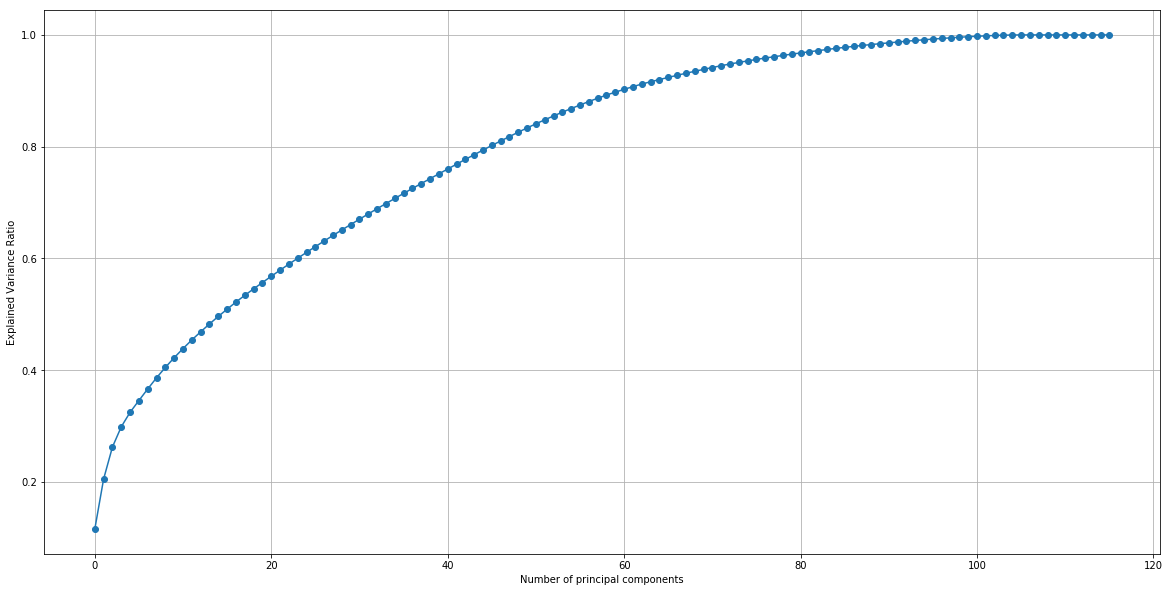

In [62]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize = (20, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('Number of principal components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [63]:
cumsum_list = np.cumsum(pca.explained_variance_ratio_)
len(cumsum_list[cumsum_list < 0.95])

73

In [64]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 74)
azdias_pca = pca.fit_transform(azdias5)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding 
dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I chose 74 principal components, which are really close to 95% of explained variance ratio of dataset.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(num):
    df = pd.DataFrame(pca.components_[num])
    df.index = azdias5.columns
    df.columns = ['PC{}'.format(num+1)]
    df = df.sort_index(by=df.columns[0], ascending = False)
    return df

In [66]:
#pd.set_option('display.max_rows',None)
pca_weights(0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,PC1
LP_STATUS_GROB_1.0,0.201231
PLZ8_ANTG3,0.192005
HH_EINKOMMEN_SCORE,0.189999
CAMEO_INTL_2015_Wealth,0.188762
PLZ8_ANTG4,0.186275
ORTSGR_KLS9,0.165751
EWDICHTE,0.164388
FINANZ_HAUSBAUER,0.148318
FINANZ_SPARER,0.140909
KBA05_ANTG4,0.135833


In [67]:
'''
LP_STATUS_GROB_1.0 : Social status, rough scale // low-income earners (maps to 1-2 in fine scale)
PLZ8_ANTG3 : Number of 6-10 family houses in the PLZ8 region
HH_EINKOMMEN_SCORE : Estimated household net income
CAMEO_INTL_2015_Wealth : German CAMEO: Wealth / Life Stage Typology, mapped to international code // wealthy, prosperous, comfortable, less affluent, poorer
PLZ8_ANTG4 : Number of 10+ family houses in the PLZ8 region


MOBI_REGIO : Movement patterns // very high movement, high movement....
FINANZ_MINIMALIST : Financial typology, MINIMALIST: low financial interest
KBA05_ANTG1 : Number of 1-2 family houses in the microcell
PLZ8_ANTG1 : Number of 1-2 family houses in the PLZ8 region
KBA05_GBZ : Number of buildings in the microcell
'''

'\nLP_STATUS_GROB_1.0 : Social status, rough scale // low-income earners (maps to 1-2 in fine scale)\nPLZ8_ANTG3 : Number of 6-10 family houses in the PLZ8 region\nHH_EINKOMMEN_SCORE : Estimated household net income\nCAMEO_INTL_2015_Wealth : German CAMEO: Wealth / Life Stage Typology, mapped to international code // wealthy, prosperous, comfortable, less affluent, poorer\nPLZ8_ANTG4 : Number of 10+ family houses in the PLZ8 region\n\n\nMOBI_REGIO : Movement patterns // very high movement, high movement....\nFINANZ_MINIMALIST : Financial typology, MINIMALIST: low financial interest\nKBA05_ANTG1 : Number of 1-2 family houses in the microcell\nPLZ8_ANTG1 : Number of 1-2 family houses in the PLZ8 region\nKBA05_GBZ : Number of buildings in the microcell\n'

In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,PC2
ALTERSKATEGORIE_GROB,0.230611
FINANZ_VORSORGER,0.214945
ZABEOTYP_3.0,0.206927
SEMIO_ERL,0.191891
SEMIO_LUST,0.163605
RETOURTYP_BK_S,0.155370
W_KEIT_KIND_HH,0.125081
FINANZ_HAUSBAUER,0.112800
CJT_GESAMTTYP_2.0,0.107286
FINANZTYP_5.0,0.095005


In [69]:
'''
ALTERSKATEGORIE_GROB : Estimated age based on given name analysis
FINANZ_VORSORGER : Financial typology, for each dimension, VORSORGER: be prepared
ZABEOTYP_3.0 : Energy consumption typology, 3 : fair supplied (1 : green, 6 : indifferent)
SEMIO_ERL : Personality typology, for each dimension, ERL: event-oriented (1: highest affinity, 7: lowest affinity)
SEMIO_LUST : Personality typology, for each dimension, LUST: sensual-minded

PRAEGENDE_JUGENDJAHRE_Decade : Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west), 40s, 50s, ...
SEMIO_REL : Personality typology, for each dimension, REL: religious
FINANZ_SPARER : Financial typology, for each dimension, SPARER: money-saver ( 1 : high, 5 : low)
FINANZ_UNAUFFAELLIGER : Financial typology, for each dimension, UNAUFFAELLIGER: inconspicuous
SEMIO_TRADV : Personality typology, for each dimension:, TRADV: tradional-minded ( 1 : high, 5 : low)
'''

"\nALTERSKATEGORIE_GROB : Estimated age based on given name analysis\nFINANZ_VORSORGER : Financial typology, for each dimension, VORSORGER: be prepared\nZABEOTYP_3.0 : Energy consumption typology, 3 : fair supplied (1 : green, 6 : indifferent)\nSEMIO_ERL : Personality typology, for each dimension, ERL: event-oriented (1: highest affinity, 7: lowest affinity)\nSEMIO_LUST : Personality typology, for each dimension, LUST: sensual-minded\n\nPRAEGENDE_JUGENDJAHRE_Decade : Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west), 40s, 50s, ...\nSEMIO_REL : Personality typology, for each dimension, REL: religious\nFINANZ_SPARER : Financial typology, for each dimension, SPARER: money-saver ( 1 : high, 5 : low)\nFINANZ_UNAUFFAELLIGER : Financial typology, for each dimension, UNAUFFAELLIGER: inconspicuous\nSEMIO_TRADV : Personality typology, for each dimension:, TRADV: tradional-minded ( 1 : high, 5 : low)\n"

In [70]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,PC3
SEMIO_VERT,0.325709
SEMIO_SOZ,0.256881
SEMIO_FAM,0.256752
SEMIO_KULT,0.244755
FINANZTYP_5.0,0.139753
FINANZ_MINIMALIST,0.135210
SHOPPER_TYP_0.0,0.126445
ZABEOTYP_1.0,0.107832
SEMIO_REL,0.098612
RETOURTYP_BK_S,0.090184


In [71]:
'''
SEMIO_VERT : Personality typology - VERT: dreamful
SEMIO_SOZ : Personality typology - SOZ: socially-minded
SEMIO_FAM : Personality typology - FAM: family-minded
SEMIO_KULT : Personality typology - KULT: cultural-minded
FINANZTYP_5.0 : Most descriptive financial type for individual, -  5: investor (ANLEGER)

SEMIO_ERL : Personality typology - ERL: event-oriented
SEMIO_KRIT : Personality typology - KRIT: critical-minded
SEMIO_DOM : Personality typology - DOM: dominant-minded
SEMIO_KAEM : Personality typology - KAEM: combative attitude
ANREDE_KZ : Gender (1 : M, 2 : F)
'''

'\nSEMIO_VERT : Personality typology - VERT: dreamful\nSEMIO_SOZ : Personality typology - SOZ: socially-minded\nSEMIO_FAM : Personality typology - FAM: family-minded\nSEMIO_KULT : Personality typology - KULT: cultural-minded\nFINANZTYP_5.0 : Most descriptive financial type for individual, -  5: investor (ANLEGER)\n\nSEMIO_ERL : Personality typology - ERL: event-oriented\nSEMIO_KRIT : Personality typology - KRIT: critical-minded\nSEMIO_DOM : Personality typology - DOM: dominant-minded\nSEMIO_KAEM : Personality typology - KAEM: combative attitude\nANREDE_KZ : Gender (1 : M, 2 : F)\n'

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the 
first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

#### PC1  
PC1 is related with low-income earners and larger family houses based on LP_STATUS_GROB_1.0, PLZ8_ANTG3, HH_EINKOMMEN_SCORE, CAMEO_INTL_2015_Wealth, PLZ8_ANTG4, which have positive correlation. However, it has negative relation with MOBI_REGIO, FINANZ_MINIMALIST, KBA05_ANTG1, PLZ8_ANTG1, and KBA05_GBZ, which means smaller family houses and low financial interest.

#### PC2  
PC2 is related with estimated ages and financially prepared based on ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3.0, SEMIO_ERL, SEMIO_LUST, which have positive relations. In constrast, it has negative relation with PRAEGENDE_JUGENDJAHRE_Decade, SEMIO_REL, FINANZ_SPARER, FINANZ_UNAUFFAELLIGER, and SEMIO_TRADV, which mean religious and traditional personality and financial situations. That means, PC2 has positive relation with religious and traditional personality, because those features are actually high in small number

#### PC3  
PC3 is related with social, cultural, and dreamful personality based on SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT, FINANZTYP_5.0, which have positive correlation. However, it has negative relation with SEMIO_ERL, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, and ANREDE_KZ which shows tendency of combative, critical minded personalities.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [72]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans, MiniBatchKMeans

clusters = list(range(10, 30))
scores = []

def kmean_score(data, numb):
    kmeans = MiniBatchKMeans(n_clusters = numb)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

    # run k-means clustering on the data and...
for cluster in clusters:
    scores.append(kmean_score(azdias_pca, cluster))
    
    
    # compute the average within-cluster distances.
scores
    

[67178665.754973963,
 65917995.724873461,
 67800577.116444305,
 66455256.249761201,
 65213133.262637042,
 64416897.84123183,
 64870696.091120869,
 63071276.694331907,
 62785849.645719394,
 63859049.171853498,
 62484271.132152446,
 61797743.702635147,
 63249724.183299854,
 61063068.351754762,
 60323784.764351889,
 63310552.205559857,
 60875819.378270872,
 59882477.178909257,
 58512939.836071678,
 60951311.634454355]

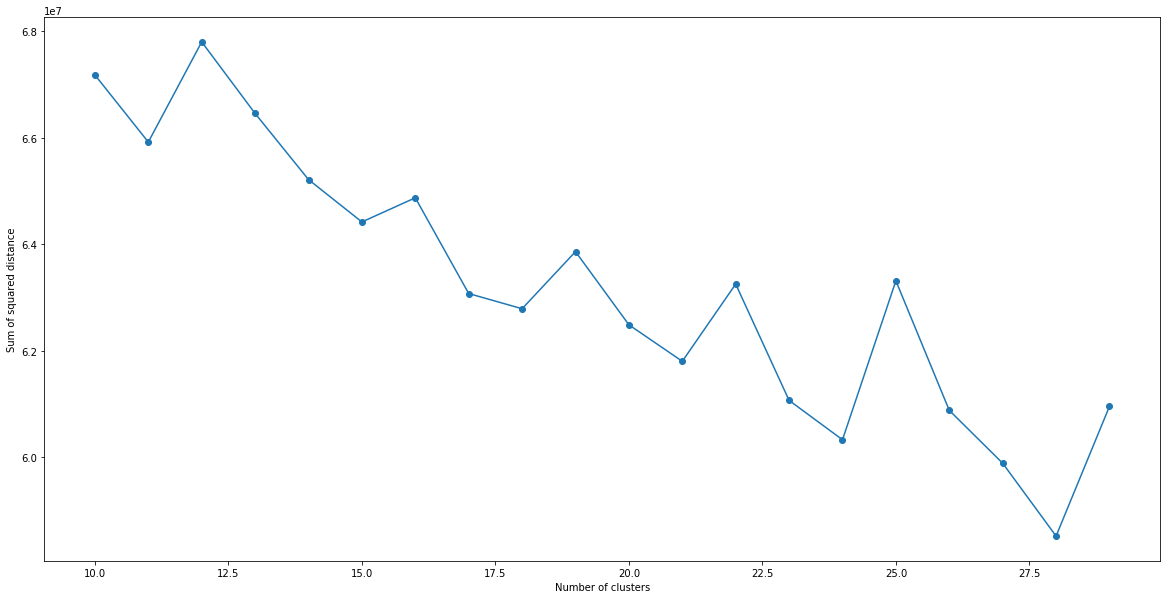

In [73]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize = (20, 10))
plt.plot(clusters, scores, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance')
plt.show()

In [74]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = MiniBatchKMeans(n_clusters = 21)
model = kmeans.fit(azdias_pca)
label = model.predict(azdias_pca)

In [75]:
label

array([20,  7, 18, ..., 10, 14,  3], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. 
Into how many clusters have you decided to segment the population?)

I chose 21 clusters. SSE plot is quiert weird but until 21, SSE is being decreased overall. After 21, the graph starts to go up and down rapidly.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [76]:
wewe = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
wewe

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


In [77]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [78]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers)
cus = customers

from sklearn.preprocessing import Imputer

imp_num = Imputer(missing_values = np.NaN, strategy = 'median')
imp_cat = Imputer(missing_values = np.NaN, strategy = 'most_frequent')

categorical_features = list(feat_info.loc[feat_info['type'] == 'categorical', 'attribute'])
customers_column_list = list(customers.columns)
customers_categorical_list = list(set(categorical_features) & set(customers_column_list))
customers_non_categorical_list = list(set(customers_column_list) - set(customers_categorical_list))

customers[customers_categorical_list] = imp_cat.fit_transform(customers[customers_categorical_list])
customers[customers_non_categorical_list] = imp_num.fit_transform(customers[customers_non_categorical_list])

for column in encoding_list:
    dummy_columns = pd.get_dummies(customers[column])

customers['GEBAEUDETYP_5.0'] = 0
customers = pd.get_dummies(customers, columns = encoding_list)

result_customer_2 = scaler.transform(customers)
customers = pd.DataFrame(result_customer_2, columns = customers.columns)

customers_pca = pca.transform(customers)

label_cus = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

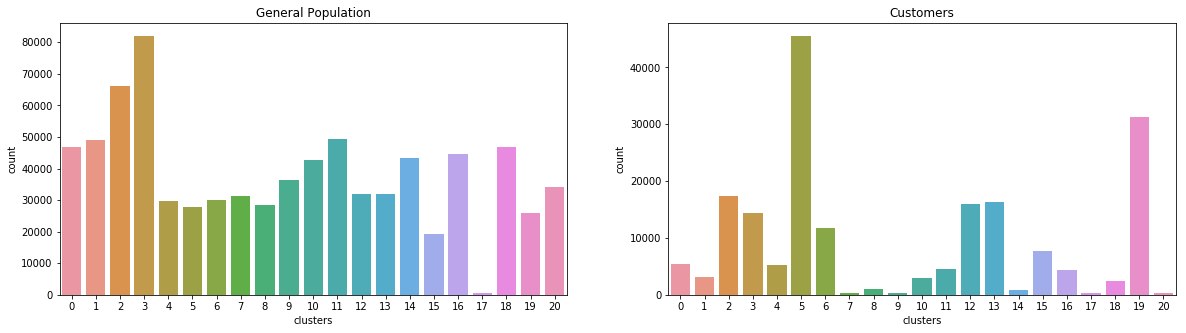

In [79]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.figure(figsize = (20,5))
    
plt.subplot(121)
sns.countplot(label)
plt.title('General Population')
plt.xlabel('clusters')
    
plt.subplot(122)
sns.countplot(label_cus)
plt.title('Customers')
plt.xlabel('clusters')
    
plt.show()

In [80]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

'''
Threshold : 0.05 (5%)
- Difference portion of same cluster between two groups : general population and customers

Cluster 12 is overrepresented in the customer data. It takes about 5.7% of dataset in general population, but 20% in customers dataset.
Cluster 9 is overrepresented in the customer data. It takes about 9.7% of dataset in general population, but 22% in customers dataset.
'''

label_final = pd.DataFrame(label)
label_final.columns = ['clusters']
azdias_final = pd.concat([azdias4, label_final], axis = 1)
cluster_8 = azdias_final.loc[azdias_final['clusters'] == 8, :]

label_cus_final = pd.DataFrame(label_cus)
label_cus_final.columns = ['clusters']
customers_final = pd.concat([cus, label_cus_final], axis = 1)
cluster_cus_8 = customers_final.loc[customers_final['clusters'] == 8, :]

print(label_final['clusters'].value_counts()/len(label_final))
print('\n')
print(label_cus_final['clusters'].value_counts()/len(label_cus_final))

3     0.102738
2     0.082986
11    0.061936
1     0.061604
18    0.058781
0     0.058738
16    0.055816
14    0.054302
10    0.053331
9     0.045524
20    0.042668
13    0.039896
12    0.039875
7     0.039375
6     0.037701
4     0.037116
8     0.035555
5     0.034808
19    0.032301
15    0.024290
17    0.000659
Name: clusters, dtype: float64


5     0.237608
19    0.163510
2     0.090680
13    0.085384
12    0.083599
3     0.075167
6     0.061747
15    0.039916
0     0.028698
4     0.027190
11    0.023704
16    0.022656
1     0.016420
10    0.015638
18    0.012397
8     0.005296
14    0.004049
7     0.001816
17    0.001743
20    0.001524
9     0.001257
Name: clusters, dtype: float64


In [81]:
general_clusters = label_final['clusters'].value_counts()/len(label_final)
general_clusters.sort_index()

customer_clusters = label_cus_final['clusters'].value_counts()/len(label_cus_final)
customer_clusters.sort_index()

difference = customer_clusters.sort_index() - general_clusters.sort_index()
print(difference)
difference > 0.05

0    -0.030040
1    -0.045183
2     0.007694
3    -0.027571
4    -0.009926
5     0.202800
6     0.024046
7    -0.037559
8    -0.030259
9    -0.044266
10   -0.037694
11   -0.038231
12    0.043724
13    0.045488
14   -0.050253
15    0.015626
16   -0.033160
17    0.001084
18   -0.046383
19    0.131209
20   -0.041145
Name: clusters, dtype: float64


0     False
1     False
2     False
3     False
4     False
5      True
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19     True
20    False
Name: clusters, dtype: bool

In [82]:
cluster_12 = azdias_final.loc[azdias_final['clusters'] == 12, :]
for column in cluster_12.columns:
    print(cluster_12[column].value_counts())
    print('\n')

3.0    11264
4.0     7907
2.0     4826
1.0     4561
Name: ALTERSKATEGORIE_GROB, dtype: int64


3.0    6480
2.0    5727
4.0    5720
5.0    5711
1.0    4920
Name: FINANZ_MINIMALIST, dtype: int64


1.0    8666
2.0    5308
5.0    5163
3.0    5014
4.0    4407
Name: FINANZ_SPARER, dtype: int64


5.0    8418
4.0    6940
3.0    5497
2.0    3919
1.0    3784
Name: FINANZ_VORSORGER, dtype: int64


1.0    7388
2.0    5764
5.0    5555
4.0    4966
3.0    4885
Name: FINANZ_ANLEGER, dtype: int64


1.0    7919
2.0    6577
3.0    5741
5.0    4253
4.0    4068
Name: FINANZ_UNAUFFAELLIGER, dtype: int64


5.0    6539
2.0    5851
3.0    5730
4.0    5627
1.0    4811
Name: FINANZ_HAUSBAUER, dtype: int64


2.0    11777
3.0    11200
1.0     5581
Name: HEALTH_TYP, dtype: int64


5.0    10012
3.0     6324
4.0     4601
1.0     4394
2.0     3227
Name: RETOURTYP_BK_S, dtype: int64


2.0    5821
6.0    4898
5.0    4404
7.0    4052
3.0    4042
4.0    3061
1.0    2280
Name: SEMIO_SOZ, dtype: int64


2.0    5090
4.0    4

In [83]:
cluster_9 = azdias_final.loc[azdias_final['clusters'] == 9, :]
for column in cluster_9.columns:
    print(cluster_9[column].value_counts())
    print('\n')

3.0    12694
4.0     9080
2.0     5676
1.0     5027
Name: ALTERSKATEGORIE_GROB, dtype: int64


3.0    7155
5.0    6584
2.0    6551
4.0    6513
1.0    5674
Name: FINANZ_MINIMALIST, dtype: int64


1.0    9848
2.0    6106
5.0    5922
3.0    5580
4.0    5021
Name: FINANZ_SPARER, dtype: int64


5.0    9461
4.0    7875
3.0    6275
2.0    4547
1.0    4319
Name: FINANZ_VORSORGER, dtype: int64


1.0    8341
2.0    6574
5.0    6298
4.0    5655
3.0    5609
Name: FINANZ_ANLEGER, dtype: int64


1.0    8966
2.0    7366
3.0    6601
5.0    4952
4.0    4592
Name: FINANZ_UNAUFFAELLIGER, dtype: int64


5.0    7524
2.0    6671
4.0    6370
3.0    6349
1.0    5563
Name: FINANZ_HAUSBAUER, dtype: int64


2.0    13639
3.0    12492
1.0     6346
Name: HEALTH_TYP, dtype: int64


5.0    11285
3.0     7138
4.0     5365
1.0     4964
2.0     3725
Name: RETOURTYP_BK_S, dtype: int64


2.0    6580
6.0    5448
5.0    5042
7.0    4660
3.0    4648
4.0    3580
1.0    2519
Name: SEMIO_SOZ, dtype: int64


2.0    5797
4.0    5

In [84]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

'''
Threshold : 0.05 (5%)
- Difference portion of same cluster between two groups : general population and customers

Cluster 3 is overrepresented in the customer data. It takes about 7.6% of dataset in general population, but 0.5% in customers dataset.
Cluster 18 is overrepresented in the customer data. It takes about 6.4% of dataset in general population, but 0.1% in customers dataset.
'''

print(difference)
difference < -0.05

0    -0.030040
1    -0.045183
2     0.007694
3    -0.027571
4    -0.009926
5     0.202800
6     0.024046
7    -0.037559
8    -0.030259
9    -0.044266
10   -0.037694
11   -0.038231
12    0.043724
13    0.045488
14   -0.050253
15    0.015626
16   -0.033160
17    0.001084
18   -0.046383
19    0.131209
20   -0.041145
Name: clusters, dtype: float64


0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14     True
15    False
16    False
17    False
18    False
19    False
20    False
Name: clusters, dtype: bool

In [85]:
cluster_3 = azdias_final.loc[azdias_final['clusters'] == 3, :]
for column in cluster_3.columns:
    print(cluster_3[column].value_counts())
    print('\n')

3.0    28979
4.0    20599
2.0    12643
1.0    11360
Name: ALTERSKATEGORIE_GROB, dtype: int64


3.0    16726
5.0    14836
4.0    14652
2.0    14643
1.0    12724
Name: FINANZ_MINIMALIST, dtype: int64


1.0    22533
2.0    13758
5.0    13188
3.0    12779
4.0    11323
Name: FINANZ_SPARER, dtype: int64


5.0    21734
4.0    17836
3.0    14241
2.0    10398
1.0     9372
Name: FINANZ_VORSORGER, dtype: int64


1.0    19141
2.0    14638
5.0    14304
4.0    12790
3.0    12708
Name: FINANZ_ANLEGER, dtype: int64


1.0    20326
2.0    17015
3.0    14847
5.0    10967
4.0    10426
Name: FINANZ_UNAUFFAELLIGER, dtype: int64


5.0    16904
2.0    15224
3.0    14668
4.0    14601
1.0    12184
Name: FINANZ_HAUSBAUER, dtype: int64


2.0    30707
3.0    28497
1.0    14377
Name: HEALTH_TYP, dtype: int64


5.0    26248
3.0    16201
4.0    11507
1.0    11313
2.0     8312
Name: RETOURTYP_BK_S, dtype: int64


2.0    15095
6.0    12656
5.0    11191
7.0    10453
3.0    10440
4.0     7994
1.0     5752
Name: SEMIO_SOZ

In [86]:
cluster_18 = azdias_final.loc[azdias_final['clusters'] == 18, :]
for column in cluster_18.columns:
    print(cluster_18[column].value_counts())
    print('\n')

3.0    16401
4.0    11705
2.0     7263
1.0     6579
Name: ALTERSKATEGORIE_GROB, dtype: int64


3.0    9507
5.0    8482
4.0    8481
2.0    8170
1.0    7308
Name: FINANZ_MINIMALIST, dtype: int64


1.0    12844
2.0     7838
5.0     7482
3.0     7272
4.0     6512
Name: FINANZ_SPARER, dtype: int64


5.0    12461
4.0    10139
3.0     7944
2.0     6000
1.0     5404
Name: FINANZ_VORSORGER, dtype: int64


1.0    11024
2.0     8390
5.0     8124
4.0     7234
3.0     7176
Name: FINANZ_ANLEGER, dtype: int64


1.0    11572
2.0     9717
3.0     8425
5.0     6313
4.0     5921
Name: FINANZ_UNAUFFAELLIGER, dtype: int64


5.0    9545
2.0    8900
3.0    8376
4.0    8146
1.0    6981
Name: FINANZ_HAUSBAUER, dtype: int64


2.0    17440
3.0    16215
1.0     8293
Name: HEALTH_TYP, dtype: int64


5.0    14797
3.0     9141
4.0     6759
1.0     6507
2.0     4744
Name: RETOURTYP_BK_S, dtype: int64


2.0    8669
6.0    7137
5.0    6325
7.0    6022
3.0    5867
4.0    4647
1.0    3281
Name: SEMIO_SOZ, dtype: int64




In [87]:
for column in cluster_18.columns:
    print('Cluster 12')
    print(cluster_12[column].value_counts())
    print('Cluster 9')
    print(cluster_9[column].value_counts())
    print('Cluster 3')
    print(cluster_3[column].value_counts())
    print('Cluster 18')
    print(cluster_18[column].value_counts())
    print('\n')

Cluster 12
3.0    11264
4.0     7907
2.0     4826
1.0     4561
Name: ALTERSKATEGORIE_GROB, dtype: int64
Cluster 9
3.0    12694
4.0     9080
2.0     5676
1.0     5027
Name: ALTERSKATEGORIE_GROB, dtype: int64
Cluster 3
3.0    28979
4.0    20599
2.0    12643
1.0    11360
Name: ALTERSKATEGORIE_GROB, dtype: int64
Cluster 18
3.0    16401
4.0    11705
2.0     7263
1.0     6579
Name: ALTERSKATEGORIE_GROB, dtype: int64


Cluster 12
3.0    6480
2.0    5727
4.0    5720
5.0    5711
1.0    4920
Name: FINANZ_MINIMALIST, dtype: int64
Cluster 9
3.0    7155
5.0    6584
2.0    6551
4.0    6513
1.0    5674
Name: FINANZ_MINIMALIST, dtype: int64
Cluster 3
3.0    16726
5.0    14836
4.0    14652
2.0    14643
1.0    12724
Name: FINANZ_MINIMALIST, dtype: int64
Cluster 18
3.0    9507
5.0    8482
4.0    8481
2.0    8170
1.0    7308
Name: FINANZ_MINIMALIST, dtype: int64


Cluster 12
1.0    8666
2.0    5308
5.0    5163
3.0    5014
4.0    4407
Name: FINANZ_SPARER, dtype: int64
Cluster 9
1.0    9848
2.0    6106
5.0 

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. 
Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular 
with the company?)

Cluster 12, 9, 3 and 18 have similar proportion of features and data set, but there are small difference.

In Cluster 9, People in this cluster are in middle age (30 ~ 60) and financially prepared. mail-order company would be popular in this cluster.

Cluster 12 is rationally high affinity and has more high power of purchasing. People in this cluster are in middle age (30 ~ 60) and mail-order company may not work better in cluster 12.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.